In [28]:
import h5py, numpy, glob

fnames = glob.glob('./inj/*INJECTIONS*.hdf')

itimes = []
idist = []
for fname in fnames:
    itime = h5py.File(fname, 'r')['injections/tc'][:]
    dist = h5py.File(fname, 'r')['injections/distance'][:]
    itimes.append(itime)
    idist.append(dist)
    
itimes = numpy.concatenate(itimes)
idist = numpy.concatenate(idist)

start = 1238166018

k = itimes > start
itimes = itimes[k]
idist = idist[k]

In [22]:
############### propuplate the trigger fits
import h5py, pylab, numpy, glob, os.path

fits = {}
ftimes = {}
for ifo in ['H1', 'L1']:
    fits[ifo] = []
    ftimes[ifo] = []

fnames = glob.glob('./fits/*.hdf')
for fname in fnames:
    name = os.path.basename(fname)
    ifo = name.split('-')[0]
    if ifo == 'V1':
        continue
    start = int(name.split('-')[2])
    dur = int(name.split('-')[3].split('.')[0])
    
    f = h5py.File(fname, 'r')
    
    alpha = f['fit_coeff'][:]
    count = f['count_in_template'][:]
    
    ftimes[ifo].append(start)
    fits[ifo].append((alpha, count))
    
for ifo in ["H1", "L1"]:
    ftimes[ifo] = numpy.array(ftimes[ifo])
    
def getnoiserate(time, stat, tid, ifo):
    s = ftimes[ifo]
    d = time - s
    l = numpy.where(d >= 0)[0]
    v = l[d[l].argmin()]
    
    alpha, count = fits[ifo][v]
    
    alphai = alpha[tid]
    ratei = count[tid]
    thresh = 5.9
    lognoisel = - alphai * (stat - thresh) + numpy.log(alphai) + numpy.log(ratei)
    return lognoisel

In [36]:
import h5py, pylab, numpy
from pycbc.events.ranking import newsnr_sgveto_psdvar_scaled_threshold
from pycbc.events.coinc import cluster_over_time
from pycbc.events.veto import indices_within_segments, segments_to_start_end, indices_outside_times, indices_within_times
from pycbc.dq import query_flag
from pycbc.conversions import mchirp_from_mass1_mass2

times = {}
nsnrs = {}
data = {}

for run in ['bbh']:
    for ifo in ['H1', 'L1']:
        print(run, ifo)
        f = h5py.File('inj/{}{}.hdf'.format(run, ifo), 'r')


        b = h5py.File('./{}.hdf'.format(run), 'r')
        m1 = b['mass1'][:]
        m2 = b['mass2'][:]
        mt = m1 + m2
        mc = mchirp_from_mass1_mass2(m1, m2)

    
        
        # Apply signal consistency tests
        snr = f['snr'][:]
        chisq = f['chisq'][:] / (f['chisq_dof'][:] * 2 - 2)
        psd_var = f['psd_var_val'][:]
        time = f['end_time'][:]
        tid = f['template_id'][:]
        sg = f['sg_chisq'][:]
        nsnr = newsnr_sgveto_psdvar_scaled_threshold(snr, chisq, sg, psd_var, threshold=1.8)

        # apply lcustering
        k = cluster_over_time(nsnr, time, 5.0)
        time = time[k]
        nsnr = nsnr[k]
        tid = tid[k]
        chisq = chisq[k]
        sg = sg[k]
        snr = snr[k]

        k = nsnr > 7
        time = time[k]
        nsnr = nsnr[k]
        tid = tid[k]
        chisq = chisq[k]
        sg = sg[k]  
        snr = snr[k]
        
        # keep only those associated with injections
        k = []
        dist = []
        for i, t in enumerate(time):
            if abs(itimes - t).min() < 0.25:
                j = abs(itimes - t).argmin()
                dist.append(idist[j])
                k.append(i)
                
        k = numpy.array(k)
        time = time[k]
        nsnr = nsnr[k]
        tid = tid[k]
        chisq = chisq[k]
        sg = sg[k]  
        snr = snr[k]
        dist = numpy.array(dist)
        
        print(len(snr), len(dist))
        
        # Apply volume sensitivity prior
        r = h5py.File('./range.hdf', 'r')
        rifo = r['ifo'][:]
        rstart = r['start'][:]
        rdist = r['range'][:]

        distr = rdist / rdist.max()
        volr = distr ** 3.0
        
        s = rstart.argsort()
        rstart = rstart[s]
        rifo = rifo[s]
        volr = volr[s]
        rstart = rstart[rifo == ifo.encode()]
        volr = volr[rifo == ifo.encode()]  
        l = numpy.searchsorted(rstart, time) - 1
        vfac = volr[l]

        # Apply mass prior
        if run == 'bbh':
            k = (mt[tid] < 130) & (sg < 3.6) 
            
            time = time[k]
            nsnr = nsnr[k]
            tid = tid[k]
            chisq = chisq[k]
            sg = sg[k]
            snr = snr[k]
            vfac = vfac[k]
            
            print(len(vfac), len(dist), len(snr))
            dist = dist[k]
            
            pfac = (mc[tid] / 20.0) ** 11.0 / 3.0
            nrate = []
            for p in zip(time, nsnr, tid):
                nrate.append(getnoiserate(*p, ifo))
            nrate = numpy.array(nrate)
            nsnr =  numpy.log(pfac) + numpy.log(vfac) - nrate
            
        else:
            nsnr = (nsnr **2.0 + 2 * numpy.log(vfac)) ** 0.5
        
        # Remove hardware injections
        segs = []
        for s, e in [(1126051217, 1137254417), (1164556817, 1187733618), (1238166018, 1253977218)]:
            if ifo == 'V1' and s == 1126051217:
                continue
            segs +=  query_flag(ifo, 'CBC_HW_INJ', s, e, cache=True)
        
        # veto time aroung gates
        gtime = h5py.File('gates.hdf', 'r')[ifo][:]

        s, e = segments_to_start_end(segs)
        s = numpy.concatenate([s, gtime - 0.5])
        e = numpy.concatenate([e, gtime + 0.5])

        #if run == 'bbh':
        #    o = h5py.File('./segs.hdf', 'a')
        #    o['{}/start'.format(ifo)] = s
        #    o['{}/end'.format(ifo)] = e
        #    o.close()
        #o = h5py.File('./segs.hdf', 'r')
        #s = o[ifo]['start'][:]
        #e = o[ifo]['end'][:]
        k = indices_outside_times(time, s, e)     
         
        time = time[k]
        nsnr = nsnr[k]
        tid = tid[k]
        chisq = chisq[k]
        sg = sg[k]
        snr = snr[k]
        dist = dist[k]
            
        
        times[(run, ifo)] = time
        nsnrs[(run, ifo)] = nsnr
        data[(run, ifo)] = time, nsnr, tid, chisq, sg, m1[tid], m2[tid], snr, dist

bbh H1
58090 58090
50494 58090 50494
bbh L1
75574 75574
66378 75574 66378


6.664087391898044
0.7541428129959219
11.0
1.135987241083304


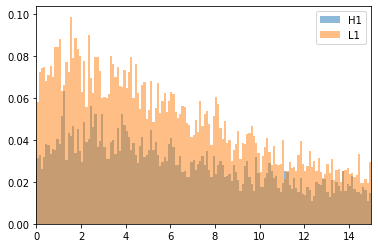

In [70]:
count = {'L1': 11, 'H1': 11 * (110 / 130) **3.0}
thresh = 0
import h5py
o = h5py.File('./signal.hdf', 'w')

for run in ['bbh']:
    for ifo in ['H1', 'L1']:
        t, s, vtid, vchisq, vsg, m1, m2, snr, dist = data[(run, ifo)]
        w = dist ** 2.0
        
        norm = w[s > thresh].sum()
        w = w / norm * count[ifo]
        
        c, b, _ = pylab.hist(s, bins=numpy.arange(0, 20, .1), weights=w, alpha=0.5, label=ifo)
        pylab.legend()
        pylab.xlim(0, 15)
        
        print(w[s>0].sum())
        print(w[(s > 10) & (s < 14)].sum())
        
        o[ifo + '/w'] = w
        o[ifo + '/s'] = s
o.close()